# Profile

In [1]:
import re
import json
from docx import Document

def parse_tick_field(text):
    """
    Given a string that uses tick markers "☒" and "☐", 
    returns a dict with "options" (list of options) 
    and "selected" (list of options marked with ☒).
    Example: "☒ Female\t\t☐ Male" becomes:
      {"options": ["Female", "Male"], "selected": ["Female"]}
    """
    # This regular expression matches a tick marker followed by text until the next tick marker (if any)
    pattern = r"(☒|☐)\s*([^☒☐]+)"
    matches = re.findall(pattern, text)
    options = []
    selected = []
    for mark, option in matches:
        option = option.strip()
        options.append(option)
        if mark == "☒":
            selected.append(option)
    return {"options": options, "selected": selected}

def clean_text(text):
    """
    Clean extra spaces, newlines, and tab characters.
    """
    return ' '.join(text.replace("\t", " ").split())

def parse_docx_to_json(doc):
    """
    Takes a python-docx Document and parses its tables into meaningful JSON.
    
    Heuristics:
      - A table with one row and one cell (non-empty) is used as a section header.
      - Other tables are assumed to contain key/value fields.
      - If a cell's text includes tick characters, we parse that cell to return both 
        the available options and the ones selected.
      - If the same key appears multiple times within a section, the values are grouped in a list.
    """
    result = {}
    current_section = "Default"  # fallback if no header is found yet
    result[current_section] = {}

    for table in doc.tables:
        # Convert table rows into lists of cleaned cell text
        table_data = []
        for row in table.rows:
            row_values = [clean_text(cell.text) for cell in row.cells]
            # Only add row if at least one cell is non-empty
            if any(row_values):
                table_data.append(row_values)
        
        # Heuristic: if this table is a single-cell header table
        if len(table_data) == 1 and len(table_data[0]) == 1:
            section_title = table_data[0][0]
            if section_title:
                current_section = section_title
                result[current_section] = {}
            continue

        # Otherwise, we treat this table as data for the current section.
        for row in table_data:
            # Assume the first cell is the key.
            key = row[0] if row[0] else None
            if not key:
                continue  # skip if no key

            # For the value, look through the remaining cells for non-empty content.
            # (Sometimes there might be multiple pieces of information.)
            value_candidates = [cell for cell in row[1:] if cell]
            if not value_candidates:
                value = None
            elif len(value_candidates) == 1:
                value = value_candidates[0]
            else:
                value = value_candidates

            # Check if this value appears to be a tick field.
            if value and isinstance(value, str) and ("☒" in value or "☐" in value):
                value = parse_tick_field(value)
            elif isinstance(value, list):
                # For lists, check if any element is a tick field.
                new_vals = []
                for v in value:
                    if "☒" in v or "☐" in v:
                        new_vals.append(parse_tick_field(v))
                    else:
                        new_vals.append(v)
                value = new_vals

            # If the key already exists, merge values in a list.
            if key in result[current_section]:
                # Convert the existing value into a list if it’s not already one.
                if not isinstance(result[current_section][key], list):
                    result[current_section][key] = [result[current_section][key]]
                result[current_section][key].append(value)
            else:
                result[current_section][key] = value

    return result

# Usage example: Load a docx file named "profile.docx" (assumed to be in the same folder)
if __name__ == "__main__":
    doc = Document("profile.docx")
    parsed_data = parse_docx_to_json(doc)
    print(json.dumps(parsed_data, indent=2, ensure_ascii=False))


{
  "Default": {},
  "Client Information": {
    "Last Name": "Vasconcelos",
    "First/ Middle Name (s)": "Joana Leonor",
    "Address": "Rua de Cedofeita 97, 0890-321 Ponta Delgada",
    "Country of Domicile": "Portugal",
    "Date of birth": "1961-07-24",
    "Nationality": "Portuguese",
    "Passport No/ Unique ID": "QG6601374",
    "ID Type": "passport",
    "ID Issue Date": "2024-06-21",
    "ID Expiry Date": "2029-06-20",
    "Gender": {
      "options": [
        "Female",
        "Male"
      ],
      "selected": [
        "Female"
      ]
    }
  },
  "Account Holder – Contact Management and Services – Contact Info": {
    "Communication Medium": "Telephone 932 718 896"
  },
  "Account Holder – Personal Info": {
    "Is the client or associated person a Politically Exposed Person as defined in the Client Acceptance Policy?": [
      {
        "options": [
          "No",
          "Yes"
        ],
        "selected": [
          "No"
        ]
      },
      "If ‘Yes’, please

In [10]:
import zipfile
from docx import Document
import os

def locate_profile(client_number: int) -> Document:
    """
    Given a client number, locate and return the Document() instance
    for the corresponding profile inside the appropriate zip archive.
    Assumes each zip contains a file named profile.docx.
    
    The archives are arranged in a cycle of 500 clients divided into
    three segments: the first 200 clients, the next 200, and then the final 100.
    For example:
      - Clients 1-200   -> folder "client_001_200"
      - Clients 201-400 -> folder "client_201_400"
      - Clients 401-500 -> folder "client_401_500"
      - Clients 501-700 -> folder "client_501_700"
      - Clients 701-900 -> folder "client_701_900"
      - Clients 901-1000-> folder "client_901_1000"
      ... and so on.
    """
    if client_number < 1:
        raise ValueError("Client number must be a positive integer.")
    
    # Determine the cycle of 500 in which the client resides.
    cycle = (client_number - 1) // 500  # 0-indexed cycle
    offset = (client_number - 1) % 500 + 1  # position within the current cycle (1 to 500)
    
    # Determine the bucket (segment) within the 500-client cycle.
    if offset <= 200:
        bucket_start = cycle * 500 + 1
        bucket_end = cycle * 500 + 200
    elif offset <= 400:
        bucket_start = cycle * 500 + 201
        bucket_end = cycle * 500 + 400
    else:
        bucket_start = cycle * 500 + 401
        bucket_end = cycle * 500 + 500
    
    # Format the folder name with zero-padding.
    folder = f"client_{str(bucket_start).zfill(3)}_{str(bucket_end).zfill(3)}"
    
    # Construct the zip file name. (The zip file name is not zero-padded.)
    zip_filename = f"client_{client_number}.zip"
    zip_path = os.path.join("data", folder, zip_filename)
    
    # Check that the zip archive exists.
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Could not find zip file: {zip_path}")
    
    # Open the zip archive and load the profile document.
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        if "profile.docx" not in zip_ref.namelist():
            raise FileNotFoundError("profile.docx not found in the zip archive.")
        with zip_ref.open("profile.docx") as docx_file:
            return Document(docx_file)


In [ ]:
doc = locate_profile(900)
parsed_data = parse_docx_to_json(doc)
print(json.dumps(parsed_data, indent=2, ensure_ascii=False))

{
  "Default": {},
  "Client Information": {
    "Last Name": "Schneider",
    "First/ Middle Name (s)": "Simon Julian",
    "Address": "Deák Ferenc tér 44, 534 40 Győr",
    "Country of Domicile": "Hungary",
    "Date of birth": "1956-07-09",
    "Nationality": "German",
    "Passport No/ Unique ID": "ZE3638628",
    "ID Type": "passport",
    "ID Issue Date": "2018-03-24",
    "ID Expiry Date": "2028-03-23",
    "Gender": {
      "options": [
        "Female",
        "Male"
      ],
      "selected": [
        "Male"
      ]
    }
  },
  "Account Holder – Contact Management and Services – Contact Info": {
    "Communication Medium": "Telephone +36 38 496 1433"
  },
  "Account Holder – Personal Info": {
    "Is the client or associated person a Politically Exposed Person as defined in the Client Acceptance Policy?": [
      {
        "options": [
          "No",
          "Yes"
        ],
        "selected": [
          "No"
        ]
      },
      "If ‘Yes’, please complete the App

# Account

In [35]:
!pip install PyPDF2
!pip install --upgrade pymupdf

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
   -------- ------------------------------- 3.4/16.6 MB 20.2 MB/s eta 0:00:01
   -------------------- ------------------- 8.7/16.6 MB 22.4 MB/s eta 0:00:01
   ---------------------- ----------------- 9.4/16.6 MB 15.4 MB/s eta 0:00:01
   ------------------------------ --------- 12.6/16.6 MB 15.5 MB/s eta 0:00:01
   ------------------------------------ --- 15.2/16.6 MB 15.2 MB/s eta 0:00:01
   ---------------------------------------  16.5/16.6 MB 14.7 MB/s eta 0:00:01
   ---------------------------------------- 16.6/16.6 MB 12.6 MB/s eta 0:00:00


{
    "account_name": "August Mathias Højgaard",
    "account_holder_name": "August Mathias",
    "account_holder_surname": "Højgaard",
    "passport_number": "TU2636946",
    "chf": "/Off",
    "eur": "/Off",
    "usd": "/Off",
    "other_ccy": "DKK",
    "building_number": "76",
    "postal_code": "4396",
    "city": "Gentofte",
    "country": "Denmark",
    "name": "August Mathias Højgaard",
    "phone_number": "+45 09 51 69 17",
    "email": "august.hjgaard@yousee.dk",
    "street_name": "Nørrebrogade",
    "signature": "iVBORw0KGgoAAAANSUhEUgAAAuMAAAC0CAIAAACxC7WVAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAMzklEQVR4nO3dZ4xlZRnA8QHXte6GtRDFxpoQcTMKKFGxFxJFxfLBrhjUBI0UW6yJiQqKIirGFqyIvUUTGzYEC1bUgIJKdjT27gpCxDLuIs/jkzl3zk65d+47e36/D/th73vPPffe2T1/2Pe878w8AECrZqZ9AgAAi5o555xztl9lbm5uOwBAM84777yZnTZt2rTz182bN88AADRj48aNMxs2bNi2bdvWrVtnZ2e3AgA0Y5999tkVLDt27Jj2P0IBACw0OzurVACARikVAKBdSgUAaJdSAQDapVQAgHYpFQCgXUoFAGiXUgEA2qVUAIB2KRUAoF1KBQBol1IBANqlVNi974SDi2mfFACDoFTYPaUCwLQoFXZPqQAwLUqFRX0zHBAuLraEs

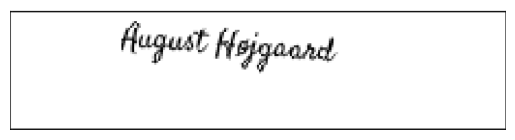

In [103]:
import zipfile
import os
import json
import base64
from io import BytesIO
import fitz
from PyPDF2 import PdfReader
from PIL import Image
import matplotlib.pyplot as plt

def locate_account(client_number: int) -> bytes:
    if client_number < 1:
        raise ValueError("Client number must be a positive integer.")
    cycle = (client_number - 1) // 500
    offset = (client_number - 1) % 500 + 1
    if offset <= 200:
        bucket_start = cycle * 500 + 1
        bucket_end = cycle * 500 + 200
    elif offset <= 400:
        bucket_start = cycle * 500 + 201
        bucket_end = cycle * 500 + 400
    else:
        bucket_start = cycle * 500 + 401
        bucket_end = cycle * 500 + 500
    folder = f"client_{str(bucket_start).zfill(3)}_{str(bucket_end).zfill(3)}"
    zip_filename = f"client_{client_number}.zip"
    zip_path = os.path.join("data", folder, zip_filename)
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Could not find zip file: {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        if "account.pdf" not in zip_ref.namelist():
            raise FileNotFoundError("account.pdf not found in the zip archive.")
        with zip_ref.open("account.pdf") as pdf_file:
            return pdf_file.read()

def extract_form_fields(pdf_bytes: bytes) -> dict:
    pdf_file = BytesIO(pdf_bytes)
    reader = PdfReader(pdf_file)
    fields = reader.get_fields()
    form_data = {}
    if fields:
        for field_name, field_info in fields.items():
            value = field_info.get('/V', '')
            form_data[field_name] = value
    else:
        print("No AcroForm fields found or the PDF is not a standard fillable form.")
    return form_data

def extract_signature_by_coordinates(pdf_bytes: bytes, ref_rect: tuple = (71, 582, 248, 625), dpi: int = 300) -> str:
    doc = fitz.open(stream=pdf_bytes, filetype="pdf")
    if doc.page_count < 1:
        print("PDF has no pages.")
        return None
    page = doc.load_page(0)
    actual_rect = page.rect
    ref_a4_width, ref_a4_height = 595, 842
    scale_x = actual_rect.width / ref_a4_width
    scale_y = actual_rect.height / ref_a4_height
    ref_x0, ref_y0, ref_x1, ref_y1 = ref_rect
    target_rect = fitz.Rect(ref_x0 * scale_x, ref_y0 * scale_y, ref_x1 * scale_x, ref_y1 * scale_y)
    zoom = dpi / 72.0
    mat = fitz.Matrix(zoom, zoom)
    try:
        pix = page.get_pixmap(matrix=mat, clip=target_rect)
        png_bytes = pix.tobytes("png")
        return base64.b64encode(png_bytes).decode("utf-8")
    except Exception as e:
        print(f"Error extracting signature region: {e}")
        return None

def extract_form_data_and_signature(pdf_bytes: bytes) -> dict:
    fitz.TOOLS.mupdf_display_errors(False)
    form_data = extract_form_fields(pdf_bytes)
    signature_b64 = extract_signature_by_coordinates(pdf_bytes, ref_rect=(71, 582, 248, 625), dpi=300)
    form_data["signature"] = signature_b64
    return form_data

def visualize_signature(signature_b64: str):
    if not signature_b64:
        print("No signature image to display.")
        return
    try:
        image_bytes = base64.b64decode(signature_b64)
        image = Image.open(BytesIO(image_bytes))
        plt.imshow(image)
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Error visualizing signature: {e}")

if __name__ == "__main__":
    try:
        account_pdf_bytes = locate_account(905)
        results = extract_form_data_and_signature(account_pdf_bytes)
        print(json.dumps(results, indent=4, ensure_ascii=False))
        if results.get("signature"):
            visualize_signature(results["signature"])
    except Exception as e:
        print(f"An error occurred: {e}")


# Description

In [104]:
import zipfile
import os
from io import BytesIO

def locate_description(client_number: int) -> str:
    if client_number < 1:
        raise ValueError("Client number must be a positive integer.")
    cycle = (client_number - 1) // 500
    offset = (client_number - 1) % 500 + 1
    if offset <= 200:
        bucket_start = cycle * 500 + 1
        bucket_end = cycle * 500 + 200
    elif offset <= 400:
        bucket_start = cycle * 500 + 201
        bucket_end = cycle * 500 + 400
    else:
        bucket_start = cycle * 500 + 401
        bucket_end = cycle * 500 + 500
    folder = f"client_{str(bucket_start).zfill(3)}_{str(bucket_end).zfill(3)}"
    zip_filename = f"client_{client_number}.zip"
    zip_path = os.path.join("data", folder, zip_filename)
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Could not find zip file: {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        if "description.txt" not in zip_ref.namelist():
            raise FileNotFoundError("description.txt not found in the zip archive.")
        with zip_ref.open("description.txt") as file:
            text = file.read().decode("utf-8")
            return text

if __name__ == "__main__":
    try:
        description = locate_description(905)
        print(description)
    except Exception as e:
        print(f"An error occurred: {e}")


Summary Note: 
August Mathias Højgaard and the RM crossed paths at a mutual friend's dinner party in Copenhagen. They discovered they had many common acquaintances and decided to explore business opportunities together.
August Mathias Højgaard is a seasoned professional with over 36 years of experience.
Seeking a trusted partner for wealth management, he joined Julius Baer for its comprehensive and tailored services.

Family Background: 
August Mathias Højgaard has been happily married to Alberte since 1995. August and Alberte have 3 children, named Mikkel, Katrine and Gitte.
Education Background: 
In 1981, August finished his secondary school education at Skt. Knuds Gymnasium.
August earned his degree from University of Southern Denmark in 1986.

Occupation History: 
August Mathias Højgaard is a 63 year old and comes from Denmark.
In 1986, August Mathias Højgaard started working as a Drilling Engineer at Chevron Denmark A/S, marking the beginning of his successful career.
In 1988, he 

In [105]:
def parse_description(text: str) -> dict:
    lines = text.splitlines()
    result = {}
    current_key = None
    current_lines = []
    for line in lines:
        stripped = line.strip()
        if not stripped:
            if current_key is not None and current_lines and current_lines[-1] != "":
                current_lines.append("")
            continue
        if stripped.endswith(":"):
            if current_key is not None:
                result[current_key] = "\n".join(current_lines).strip()
            current_key = stripped[:-1].strip()
            current_lines = []
        else:
            if current_key is not None:
                current_lines.append(stripped)
    if current_key is not None:
        result[current_key] = "\n".join(current_lines).strip()
    return result

In [106]:
import json
description = locate_description(905)
parsed = parse_description(description)
print(json.dumps(parsed, indent=4, ensure_ascii=False))

{
    "Summary Note": "August Mathias Højgaard and the RM crossed paths at a mutual friend's dinner party in Copenhagen. They discovered they had many common acquaintances and decided to explore business opportunities together.\nAugust Mathias Højgaard is a seasoned professional with over 36 years of experience.\nSeeking a trusted partner for wealth management, he joined Julius Baer for its comprehensive and tailored services.",
    "Family Background": "August Mathias Højgaard has been happily married to Alberte since 1995. August and Alberte have 3 children, named Mikkel, Katrine and Gitte.",
    "Education Background": "In 1981, August finished his secondary school education at Skt. Knuds Gymnasium.\nAugust earned his degree from University of Southern Denmark in 1986.",
    "Occupation History": "August Mathias Højgaard is a 63 year old and comes from Denmark.\nIn 1986, August Mathias Højgaard started working as a Drilling Engineer at Chevron Denmark A/S, marking the beginning of h